# Ch 5. Interactive Data Analysis

This notebook introduces carrying out interactive data analysis of data in BigQuery using a Jupyter Notebook managed by Vertex AI Workbench.

This cell, for example, is a mark-down cell.  Which is why you are seeing text. The cell that follows is a Python code cell. The output of that cell is whatever is printed out from it.

In [ ]:
a = 3
b = a + 5
print("a={} b={}".format(a,b))

## Relative path

I created this notebook in 05_bqnotebook folder of the git repo for the book. So, you might see a path that ends in that. But the path will start with /home/jupyter which is mapped to a local folder if you are running this in a container.

In [ ]:
!pwd

## What's installed?

In [ ]:
%pip freeze

In [ ]:
%pip install seaborn

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from google.cloud import bigquery

## Installing dependencies

Regular Python dependencies can be installed using pip

In [ ]:
%pip install pytz

## Juypter magic

In [2]:
%%html
This cell will print out a <b> HTML </b> string.

El cell magic `%%bigquery` nos retorna los resultados de la consulta en
SQL en un DataFrame de pandas.


El sintaxis de la celda mágica es el siguiente:

```
%%bigquery [<destination_var>] [--project <project>] [--use_legacy_sql]
           [--verbose] [--params <params>] <query>
```

Obs. si nos encontramos en un ambiente local, antes de ejecutar la celda
debemos ejecutar la linea mágica load_ext la cual carga las funciones
mágicas por su nombre de módulo.

In [4]:
%load_ext google.cloud.bigquery

In [5]:
%%bigquery
SELECT 
  COUNTIF(arr_delay >= 15)/COUNT(arr_delay) AS frac_delayed
FROM dsongcp.flights_tzcorr

Query is running:   0%|          |

Downloading:   0%|          |

,frac_delayed
0,0.219494


## Calls to BigQuery
We can also directly query BigQuery with the Python library:

In [6]:
bq = bigquery.Client()

In [7]:
sql = """
SELECT
  COUNTIF(arr_delay >= 15)/COUNT(arr_delay) AS frac_delayed
FROM dsongcp.flights_tzcorr
"""
bq.query(sql).to_dataframe()

,frac_delayed
0,0.219494


Let's draw a Probability Distribution Function (PDF) of different arrival delays. In a Notebook we can assign the output of a cell magic query to a variable, in this case `df`:

In [8]:
%%bigquery df
SELECT ARR_DELAY, DEP_DELAY
FROM dsongcp.flights_tzcorr
WHERE DEP_DELAY >= 10

Query is running:   0%|          |

Downloading:   0%|          |

In [9]:
type(df)

pandas.core.frame.DataFrame

In [10]:
df.describe()

,ARR_DELAY,DEP_DELAY
count,1.734356e+06,1.743880e+06
mean,5.624196e+01,6.094439e+01
std,9.839818e+01,9.704787e+01
min,-8.100000e+01,1.000000e+01
25%,1.200000e+01,1.800000e+01
50%,3.000000e+01,3.300000e+01
75%,6.600000e+01,6.700000e+01
max,4.405000e+03,4.413000e+03


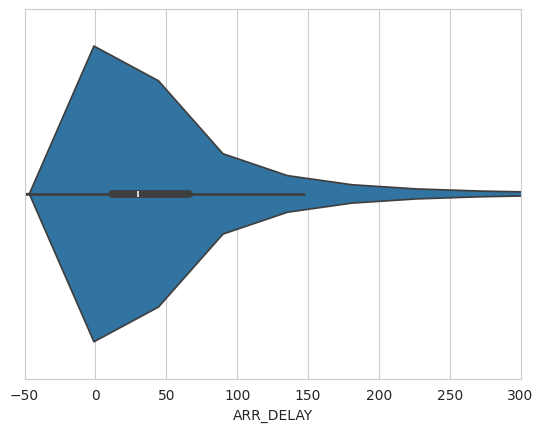

In [11]:
sns.set_style("whitegrid")
# sns.set(font_scale = 1.5)
ax = sns.violinplot(data=df, x='ARR_DELAY', inner='box', orient='h')
ax.axes.set_xlim(-50, 300);

## Visualizando distribuciones

In [12]:
%%bigquery df
SELECT ARR_DELAY, DEP_DELAY
FROM dsongcp.flights_tzcorr

Query is running:   0%|          |

Downloading:   0%|          |

In [13]:
df.describe()

,ARR_DELAY,DEP_DELAY
count,6.678463e+06,6.699431e+06
mean,8.216988e+00,1.346740e+01
std,5.887879e+01,5.711700e+01
min,-1.190000e+02,-7.200000e+01
25%,-1.400000e+01,-5.000000e+00
50%,-5.000000e+00,-2.000000e+00
75%,1.100000e+01,1.100000e+01
max,4.405000e+03,4.413000e+03


In [14]:
df['ontime'] = df['DEP_DELAY'] < 10
df[df['ARR_DELAY'] > 0].head()

,ARR_DELAY,DEP_DELAY,ontime
0,239.0,207.0,False
1,97.0,104.0,False
2,117.0,145.0,False
3,34.0,47.0,False
4,24.0,-6.0,True


In [17]:
sns.set_style("whitegrid")

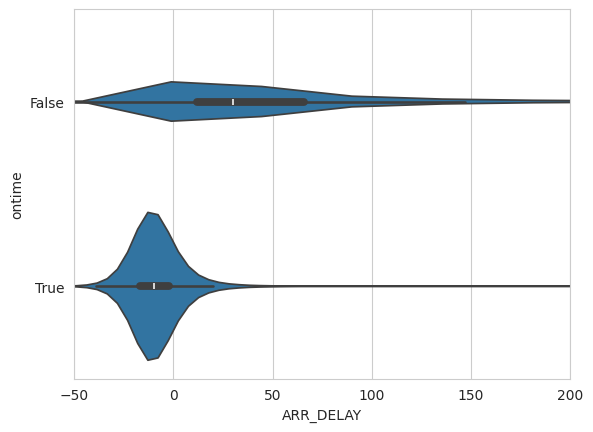

In [18]:
ax = sns.violinplot(data=df, x='ARR_DELAY', y='ontime', inner='box', orient='h')
ax.set_xlim(-50, 200);

(-50.0, 200.0)

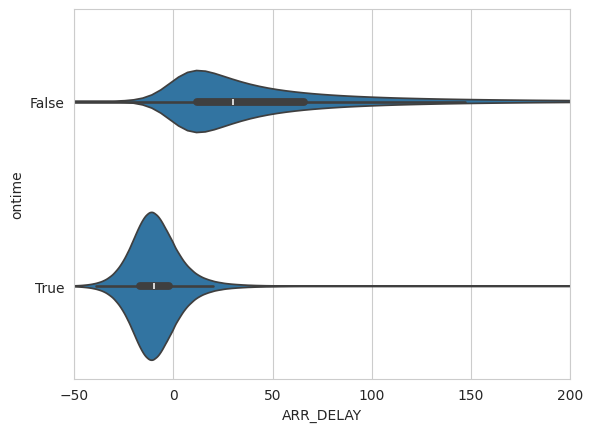

In [16]:
ax = sns.violinplot(data=df, x='ARR_DELAY', y='ontime', 
                    inner='box', orient='h', gridsize=1000)
ax.set_xlim(-50, 200)

## Oddball values

In [ ]:
%%bigquery depdelay
SELECT
  DEP_DELAY,
  AVG(ARR_DELAY) AS arrival_delay,
  COUNT(ARR_DELAY) AS numflights
FROM
  dsongcp.flights_tzcorr
GROUP BY
  DEP_DELAY
ORDER BY
  DEP_DELAY

In [ ]:
len(depdelay)

In [ ]:
depdelay[:5]

In [ ]:
depdelay[55:60]

## Filtering Data on Occurence Frequency

In [ ]:
%%bigquery df
DECLARE total_flights INT64;
SET total_flights = (
    SELECT COUNT(*) FROM dsongcp.flights_tzcorr
);

CREATE TEMPORARY FUNCTION linear_fit(NUM_TOTAL INT64, THRESH INT64)
RETURNS STRUCT<thresh INT64, num_removed INT64, lm FLOAT64>
AS ((
    SELECT AS STRUCT
        THRESH,
        (NUM_TOTAL - SUM(numflights)) AS num_removed,
        ROUND(AVG(arrival_delay * numflights) / AVG(dep_delay * numflights), 2) AS lm
    FROM
    (
        SELECT
            DEP_DELAY,
            AVG(ARR_DELAY) AS arrival_delay,
            STDDEV(ARR_DELAY) AS stddev_arrival_delay,
            COUNT(ARR_DELAY) AS numflights
        FROM
            dsongcp.flights_tzcorr
        GROUP BY
            DEP_DELAY
    )
    WHERE numflights > THRESH
))
;

SELECT linear_fit(total_flights, 1000) stats
UNION ALL SELECT linear_fit(total_flights, 500)
UNION ALL SELECT linear_fit(total_flights, 370)
UNION ALL SELECT linear_fit(total_flights, 300)
UNION ALL SELECT linear_fit(total_flights, 200)
UNION ALL SELECT linear_fit(total_flights, 100)
UNION ALL SELECT linear_fit(total_flights, 22)
UNION ALL SELECT linear_fit(total_flights, 10)
UNION ALL SELECT linear_fit(total_flights, 5)
ORDER BY stats.thresh DESC

In [ ]:
df['stats'].map(lambda x: (x['thresh'], x['num_removed'], x['lm']))

## Arrival delay conditioned on departure delay

In [ ]:
%%bigquery depdelay
SELECT
    DEP_DELAY,
    AVG(ARR_DELAY) AS arrival_delay,
    STDDEV(ARR_DELAY) AS stddev_arrival_delay,
    COUNT(ARR_DELAY) AS numflights
FROM
    dsongcp.flights_tzcorr
GROUP BY
    DEP_DELAY
HAVING numflights > 370
ORDER BY DEP_DELAY

In [ ]:
depdelay[:5]

In [ ]:
ax = depdelay.plot(kind='line', x='DEP_DELAY', 
              y='arrival_delay', yerr='stddev_arrival_delay')

In [ ]:
Z_30 = 0.52
depdelay['arr_delay_30'] = (Z_30 * depdelay['stddev_arrival_delay']) \
             + depdelay['arrival_delay']

ax = plt.axes()
depdelay.plot(kind='line', x='DEP_DELAY', y='arr_delay_30',
              ax=ax, ylim=(0,30), xlim=(0,30), legend=False)
ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% prob of this\n Arrival Delay (minutes)');

x = np.arange(0, 30)
y = np.ones_like(x) * 15
ax.plot(x, y, 'r.');

y = np.arange(0, 30)
x = np.ones_like(y) * 13
ax.plot(x, y, 'g.');

In [ ]:
%%bigquery depdelay
SELECT
    DEP_DELAY,
    APPROX_QUANTILES(ARR_DELAY, 101)[OFFSET(70)] AS arrival_delay,
    COUNT(ARR_DELAY) AS numflights
FROM
    dsongcp.flights_tzcorr
GROUP BY
    DEP_DELAY
HAVING numflights > 370
ORDER BY DEP_DELAY

In [ ]:
ax = plt.axes()
depdelay.plot(kind='line', x='DEP_DELAY', y='arrival_delay',
              ax=ax, ylim=(0,30), xlim=(0,30), legend=False)
ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% prob of this\n Arrival Delay (minutes)');

x = np.arange(0, 30)
y = np.ones_like(x) * 15
ax.plot(x, y, 'r.');

y = np.arange(0, 30)
x = np.ones_like(y) * 16
ax.plot(x, y, 'g.');

## Creating training/evaluation dataset

In [ ]:
%%bigquery
SELECT
  FL_DATE,
  IF(ABS(MOD(FARM_FINGERPRINT(CAST(FL_DATE AS STRING)), 100)) < 70,
     'True', 'False') AS is_train_day
FROM (
  SELECT
    DISTINCT(FL_DATE) AS FL_DATE
  FROM
    dsongcp.flights_tzcorr)
ORDER BY
  FL_DATE
LIMIT 5

In [ ]:
%%bigquery
CREATE OR REPLACE TABLE dsongcp.trainday AS

SELECT
  FL_DATE,
  IF(ABS(MOD(FARM_FINGERPRINT(CAST(FL_DATE AS STRING)), 100)) < 70,
     'True', 'False') AS is_train_day
FROM (
  SELECT
    DISTINCT(FL_DATE) AS FL_DATE
  FROM
    dsongcp.flights_tzcorr)
ORDER BY
  FL_DATE

In [ ]:
%%bigquery depdelay
SELECT
    DEP_DELAY,
    APPROX_QUANTILES(ARR_DELAY, 101)[OFFSET(70)] AS arrival_delay,
    COUNT(ARR_DELAY) AS numflights
FROM
    dsongcp.flights_tzcorr
JOIN dsongcp.trainday USING(FL_DATE)
WHERE is_train_day = 'True'
GROUP BY
    DEP_DELAY
HAVING numflights > 370
ORDER BY DEP_DELAY

In [ ]:
ax = plt.axes()
depdelay.plot(kind='line', x='DEP_DELAY', y='arrival_delay',
              ax=ax, ylim=(0,30), xlim=(0,30), legend=False)
ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% prob of this\n Arrival Delay (minutes)');

x = np.arange(0, 30)
y = np.ones_like(x) * 15
ax.plot(x, y, 'r.');

y = np.arange(0, 30)
x = np.ones_like(y) * 16
ax.plot(x, y, 'g.');

In [ ]:
%%bigquery df_eval
SELECT
  SUM(IF(DEP_DELAY < 16
      AND arr_delay < 15, 1, 0)) AS correct_nocancel,
  SUM(IF(DEP_DELAY < 16
      AND arr_delay >= 15, 1, 0)) AS wrong_nocancel,
  SUM(IF(DEP_DELAY >= 16
      AND arr_delay < 15, 1, 0)) AS wrong_cancel,
  SUM(IF(DEP_DELAY >= 16
      AND arr_delay >= 15, 1, 0)) AS correct_cancel
FROM (
  SELECT
    DEP_DELAY,
    ARR_DELAY
  FROM
    dsongcp.flights_tzcorr
  JOIN dsongcp.trainday USING(FL_DATE)
  WHERE is_train_day = 'False' 
)

In [ ]:
print(df_eval['correct_nocancel'] /
      (df_eval['correct_nocancel'] + df_eval['wrong_nocancel']))
print(df_eval['correct_cancel'] / 
      (df_eval['correct_cancel'] + df_eval['wrong_cancel']))

In [ ]:
df_eval.head()

In [ ]:
%%bigquery df_eval
SELECT
  SUM(IF(DEP_DELAY = 15
      AND arr_delay < 15, 1, 0)) AS correct_nocancel,
  SUM(IF(DEP_DELAY = 15
      AND arr_delay >= 15, 1, 0)) AS wrong_nocancel,
  SUM(IF(DEP_DELAY = 16
      AND arr_delay < 15, 1, 0)) AS wrong_cancel,
  SUM(IF(DEP_DELAY = 16
      AND arr_delay >= 15, 1, 0)) AS correct_cancel
FROM (
  SELECT
    DEP_DELAY,
    ARR_DELAY
  FROM
    dsongcp.flights_tzcorr
  JOIN dsongcp.trainday USING(FL_DATE)
  WHERE is_train_day = 'False' 
)

In [ ]:
df_eval.head()

In [ ]:
print(df_eval['correct_nocancel'] / (df_eval['correct_nocancel'] + df_eval['wrong_nocancel']))
print(df_eval['correct_cancel'] / (df_eval['correct_cancel'] + df_eval['wrong_cancel']))

Copyright 2021 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.